## Notebook to practice inference & clustering & stats analysis 

You can ask question to Takuya when you have stacked at some parts. Accurate job is necessary rather than just finishing fast!

In [1]:
%reload_ext autoreload
%autoreload 2
import os
import sys
import glob
import numpy as np
import scipy as sc
import pandas as pd
import tensorflow as tf
from pyhdf.SD import SD, SDC 
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import patches as mpl_patches
from sklearn.cluster import AgglomerativeClustering

---------------
### Prerequisites
Libraries below are necessary to download on you laptop (If disk amount is issue, we can move to Midway cluster-computer where the analysis is much easier if you have already got the access)

1. Tensorflow 1.12.0 for CPU [stackoverflow How to install CPU version of Tnesorflow](https://stackoverflow.com/questions/53614262/how-to-install-cpu-version-of-tensorflow-using-conda)
2. Agglometative clustering from scikit-learn.  
 How to donwload agglomerative [sklearn aggl](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)  

`from sklearn.cluster import AgglomerativeClustering`

### Helpful resource
- `clouds/analysis_mod021KM/017_m2_02_clustering-stats_with-without_DNNprocessing.ipynb`  (Workflow in your task is almost same as this 017 notebook)
- `clouds/analysis_mod021KM/016_m2_02_clustering_with-without_CloudFlags.ipynb`  
These notebooks contain lot of original function/analysis (especially 017)

### Load a trained DNN model
Model name: `m2_04_global_2000_2018_band28_29_31`  
Model Directory: ```/project2/foster/clouds/model/m2_04_global_2000_2018_band28_29_31```

In [2]:
# model directory path
modeldir = "../model_m2_04"
step = 100000 # DO NOT CHANGE so far

In [3]:
encoder_def = modeldir+'/encoder.json'
encoder_weight = modeldir+'/encoder-'+str(step)+'.h5'
with open(encoder_def, "r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(encoder_weight)

W0716 09:45:09.671436 140354903291712 deprecation.py:506] From /home/sydneyjenkins/.conda/envs/env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0716 09:45:09.672886 140354903291712 deprecation.py:506] From /home/sydneyjenkins/.conda/envs/env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0716 09:45:09.673960 140354903291712 deprecation.py:506] From /home/sydneyjenkins/.conda/envs/env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py

### Data description
Test image can be any date of hdf file.  
However, it is interesting to use same dataset which I used in 017 notebook. These data are placed at  
   - MOD02 ```/project2/foster/clouds/data/shared/test_img/MOD02/20150628```
   - MOD35 ```/project2/foster/clouds/data/shared/test_img/MOD35/20150628```
   - MOD06 ```/project2/foster/clouds/data/shared/test_img/MOD06/20150628```

### Necessary Files
##### MOD02
Using band: Following band information is necessary.
*Visible bands*  
- Band 6 : XXX_EV_500_Aggr1km_RefSB_4.hdf
- Band 7 : XXX_EV_500_Aggr1km_RefSB_5.hdf
*Thermal bands*  
- Band 20: YYY_.EV_1KM_Emissive_1.hdf
- Band 28: YYY_EV_1KM_Emissive_8.hdf
- Band 29: YYY_EV_1KM_Emissive_9.hdf
- Band 31: YYY_EV_1KM_Emissive_11.hdf

##### MOD35
- Layer 0: ZZZ_Cloud_Mask_1.hdf  
(IN general, MOD35 has 6 layers-3D array. But here, each layer splits into each file. So Mask_1 corresponds to layer 1)

### Load MODIS 02, 35 data below
- Try to code by yourself based on practice notebook (firstly look into notebooks, and then if anything questions you havev, ask Takuya how to do this.)


- (**IMPORTANT**) These files are separated by each variable s.t. temperature data is downloaded as XXX_Clouds_top_temperature.hdf. So, you may need to modify loading functions you have coded until yesterday for this dataset.

In [4]:
from alignment_lib import  decode_cloud_flag, const_clouds_array
from analysis_lib import _get_colors, _gen_patches
from lib_modis02 import proc_sds

In [5]:
mod02_filelist = glob.glob("../tak_data/MOD02/*RefSB*.hdf")
mod02_filelist.sort()
mod02_filelist

['../tak_data/MOD02/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.Band_1KM_RefSB.hdf',
 '../tak_data/MOD02/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_RefSB_1.hdf',
 '../tak_data/MOD02/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_RefSB_10.hdf',
 '../tak_data/MOD02/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_RefSB_11.hdf',
 '../tak_data/MOD02/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_RefSB_12.hdf',
 '../tak_data/MOD02/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_RefSB_13.hdf',
 '../tak_data/MOD02/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_RefSB_14.hdf',
 '../tak_data/MOD02/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_RefSB_15.hdf',
 '../tak_data/MOD02/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_RefSB_2.hdf',
 '../tak_data/MOD02/MOD021KM.A2015179.mosaic.061.201911216

In [6]:
hdf_filelist=[
    '../tak_data/MOD02/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_500_Aggr1km_RefSB_4.hdf',
    '../tak_data/MOD02/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_500_Aggr1km_RefSB_5.hdf',
    '../tak_data/MOD02/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_Emissive_1.hdf',
    '../tak_data/MOD02/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_Emissive_8.hdf',
    '../tak_data/MOD02/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_Emissive_9.hdf',
    '../tak_data/MOD02/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_Emissive_11.hdf'
]

b6_hdf = (SD(hdf_filelist[0], SDC.READ)).select("EV_500_Aggr1km_RefSB")
b7_hdf = (SD(hdf_filelist[1], SDC.READ)).select("EV_500_Aggr1km_RefSB")
b20_hdf = (SD(hdf_filelist[2], SDC.READ)).select("EV_1KM_Emissive")
b28_hdf = (SD(hdf_filelist[3], SDC.READ)).select("EV_1KM_Emissive")
b29_hdf = (SD(hdf_filelist[4], SDC.READ)).select("EV_1KM_Emissive")
b31_hdf = (SD(hdf_filelist[5], SDC.READ)).select("EV_1KM_Emissive")

In [7]:
#Decoding 
b6_array, b6 = proc_sds(b6_hdf)
b7_array, b7 = proc_sds(b7_hdf)
b20_array, b20 = proc_sds(b20_hdf)
b28_array, b28 = proc_sds(b28_hdf)
b29_array, b29 = proc_sds(b29_hdf)
b31_array, b31 = proc_sds(b31_hdf)

Process bands 6


/scratch/midway2/sydneyjenkins/clouds/analysis_mod021KM/lib_modis02.py:90: RuntimeWarning: invalid value encountered in greater
  invalid_idx = np.where( array > 32767 )


Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31


In [8]:
nx, ny = b6_array.shape

d_list = [
    b6_array.reshape(nx,ny,1),
    b7_array.reshape(nx,ny,1),
    b20_array.reshape(nx,ny,1),
    b28_array.reshape(nx,ny,1),
    b29_array.reshape(nx,ny,1),
    b31_array.reshape(nx,ny,1),
]

mod02_img = np.concatenate(d_list, axis=2)

In [329]:
mod02_img.shape

(4513, 4748, 6)

In [9]:
fig = plt.figure(figsize=(14,10))
bands = [6, 7, 20, 28, 29, 31] 

for i in range(mod02_img.shape[2]):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(mod02_img[:,:,i], cmap='jet')
    ax.set_title("Band %d" % (bands[i]))
    plt.colorbar()
fig.tight_layout()
plt.savefig("Compare/Decoded_data")
plt.close()

In [11]:
#MOD35
mod35_filelist = glob.glob("../tak_data/MOD35/*.hdf")
mod35_filelist.sort()

hdf_cm1 = SD(mod35_filelist[0], SDC.READ)
cm1_sds = hdf_cm1.select('Cloud_Mask')

#Extract cloud flag info
cloud_mask = decode_cloud_flag(cm1_sds)

### Alignment MOD02 + MOD35

In [12]:

patches = _gen_patches(mod02_img, normalization=False)

In [13]:
clouds_patches_list, clouds_xy_list = const_clouds_array(patches, cloud_mask)

In [14]:
nx, ny = patches.shape[:2]

In [15]:
reconst_array = np.zeros((nx*128, ny*128, 6)).astype(float)
clouds_patches_list = np.squeeze(np.asarray(clouds_patches_list))
reconst_array[:,:,:]=np.nan
idx = 0
for i in range(nx):
    for j in range(ny):
        if (i,j) in clouds_xy_list:
            reconst_array[i*128 : (i+1)*128, j*128 : (j+1)*128] = clouds_patches_list[idx]
            idx += 1

In [16]:
fig = plt.figure(figsize=(12,10))
bands = [6, 7, 20, 28, 29, 31] 
for idx in range(6):
    ax = plt.subplot(3, 3, idx+1)
    if idx<6:
        plt.imshow(reconst_array[:,:,idx])
        plt.title("Band %d" % (bands[idx]))
    else:
        pass#plt.imshow(cloud_mask, cmap='jet')
plt.savefig("Compare/Aligned_data.png")
plt.close()

### Clustering
1. Start at N = 12  (N is number of clusters)
2. Next try N = 48
3. Next vary the N. Apply N = 4, 8, 12, ... 80 (every4) or you can do every (2)

In [17]:
n_clusters = 12

In [18]:
method = AgglomerativeClustering(n_clusters=n_clusters)

In [19]:
"""
clouds_patch_list[i] = np.ndarray[128,128,6]
""" 
mean1_list = []
for i in clouds_patches_list:
    mean1_list += [i.ravel()]
mean1_array = np.asarray(mean1_list)

"""
clouds_patch_list[i] = np.ndarray[128,128,6] --> mean compute!
"""
mean2_list = []
for i in clouds_patches_list:
    mean2_list += [np.squeeze(np.mean(i, axis=(0,1))) ]
mean2_array = np.asarray(mean2_list)

In [21]:
patches1_labels = method.fit_predict(mean1_array)
patches2_labels = method.fit_predict(mean2_array)

In [22]:
def compute_agl(encoder, patches_list,n_cluster = 10):
    encs_list = []
    for i in patches_list:
        encs = encoder.predict(i.reshape(1,128,128,6))
        encs_list += [encs.mean(axis=(1,2))]
    features = np.concatenate(encs_list, axis=0)
    print(features.shape)
    method = AgglomerativeClustering(n_clusters=n_cluster)
    _patches_labels = method.fit_predict(features)
    return _patches_labels

In [23]:
clouds_patches_labels = compute_agl(encoder, clouds_patches_list, n_cluster=n_clusters)

(806, 1024)


In [24]:
def reconst_img(_patches, _patches_labels, _xy_list):
    ix, iy = _patches.shape[:2]
    img_array = np.zeros((ix,iy)).astype(np.float64)
    img_array[:,:] = np.nan
    for idx, (x,y) in enumerate(_xy_list):
        img_array[x,y] = _patches_labels[idx]
    return img_array

In [25]:
img1_array = reconst_img(patches, patches1_labels, clouds_xy_list)
img2_array = reconst_img(patches, patches2_labels, clouds_xy_list)
cimg_array = reconst_img(patches, clouds_patches_labels, clouds_xy_list)

In [89]:
cimg_array

array([[nan, nan, nan, ...,  5.,  4.,  1.],
       [nan, nan, nan, ...,  5.,  5.,  5.],
       [nan, nan, nan, ...,  1., nan,  1.],
       ...,
       [ 9.,  9.,  9., ..., nan, nan, nan],
       [ 2.,  9.,  9., ...,  3., nan, nan],
       [ 2., nan,  2., ..., nan, nan, nan]])

In [ ]:
#4
fig = plt.figure(figsize=(13,13))
ax = plt.subplot(131)
plt.imshow(img1_array, cmap='jet')
ax.set_title("# mean 1 without model")
#plt.colorbar(orientation='horizontal')
ax = plt.subplot(132)
plt.imshow(img2_array, cmap='jet')
ax.set_title("# mean 2 without model")
#plt.colorbar(orientation='horizontal')
fig.tight_layout
ax = plt.subplot(133)
plt.imshow(cimg_array, cmap='jet')
ax.set_title("# cloud with model " )
#plt.colorbar(orientation='horizontal')
fig.tight_layout
plt.savefig("Compare/Clustering04_04")
plt.close()

In [361]:
#48
fig = plt.figure(figsize=(13,13))
ax = plt.subplot(131)
plt.imshow(img1_array, cmap='jet')
ax.set_title("# mean 1 without model")
#plt.colorbar(orientation='horizontal')
ax = plt.subplot(132)
plt.imshow(img2_array, cmap='jet')
ax.set_title("# mean 2 without model")
#plt.colorbar(orientation='horizontal')
fig.tight_layout
ax = plt.subplot(133)
plt.imshow(cimg_array, cmap='jet')
ax.set_title("# cloud with model " )
#plt.colorbar(orientation='horizontal')
fig.tight_layout
plt.savefig("Compare/Clustering48_04")
plt.close()

In [352]:
#12
fig = plt.figure(figsize=(13,13))
ax = plt.subplot(131)
plt.imshow(img1_array, cmap='jet')
ax.set_title("# mean 1 without model")
#plt.colorbar(orientation='horizontal')
ax = plt.subplot(132)
plt.imshow(img2_array, cmap='jet')
ax.set_title("# mean 2 without model")
#plt.colorbar(orientation='horizontal')
fig.tight_layout
ax = plt.subplot(133)
plt.imshow(cimg_array, cmap='jet')
ax.set_title("# cloud with model " )
#plt.colorbar(orientation='horizontal')
fig.tight_layout
plt.savefig("Compare/Clustering12_04")
plt.close()

### Compare with MOD06
0. Decode MOD06
1. Compute patch-wise mean (mean of physics parameter within a patch) with respect to 4 clouds physics parameters as follwoing
 - optical thickness
 - water path
 - particle phase
 - top pressure
 
2. About `Cloud Phase Infrared`, you should compute mode. Ask me if you have trouble.

3. compute distributions, mean, stdv of these clouds physics parameters 

4. Plot histogram about the distribution. Add mean and std information on these figures

At first from N = 12 case.

In [26]:
mod06_filelist = glob.glob("../tak_data/MOD06/*article*.hdf")
mod06_filelist.sort()
mod06_filelist

[]

In [27]:
hdf_filelist=[
    '../tak_data/MOD06/MOD06_L2.A2015179.mosaic.061.2019122231923.mcgscs_000501331914.Cloud_Water_Path.hdf',
    '../tak_data/MOD06/MOD06_L2.A2015179.mosaic.061.2019122231923.mcgscs_000501331914.Cloud_Phase_Infrared.hdf',
    '../tak_data/MOD06/MOD06_L2.A2015179.mosaic.061.2019122231923.mcgscs_000501331914.Cloud_Top_Pressure.hdf',
    '../tak_data/MOD06/MOD06_L2.A2015179.mosaic.061.2019122231923.mcgscs_000501331914.Cloud_Optical_Thickness.hdf'    
]

hdf_water_path = (SD(hdf_filelist[0], SDC.READ)).select("Cloud_Water_Path")
hdf_phase_infrared = (SD(hdf_filelist[1], SDC.READ)).select("Cloud_Phase_Infrared")
hdf_top_pressure = (SD(hdf_filelist[2], SDC.READ)).select("Cloud_Top_Pressure")
hdf_optical_thickness = (SD(hdf_filelist[3], SDC.READ)).select("Cloud_Optical_Thickness")

In [28]:
## decoding process
"""When you want to check how each line affects output, just comment off and process steps. 
   Initially, all process are NOT commented out. 
"""

params = [hdf_water_path,hdf_phase_infrared,hdf_top_pressure,hdf_optical_thickness]
decoded = []

for hdf_sds in params:
    array = hdf_sds.get()
    array = array.astype(np.float64)
    
    # Get FillValue index
    nan_idx = np.where( array == hdf_sds.attributes()['_FillValue'])
    if len(nan_idx) > 0:
        array[nan_idx] = np.nan
    else:
        pass
    
    # radiance offset
    offset = hdf_sds.attributes()['add_offset']
    array = array - offset
    
    # radiance scale
    scales = hdf_sds.attributes()['scale_factor']
    array = array*scales
    
    ### Error Value process
    if str(hdf_sds) == 'hdf_optical_thickness':
        err_idx = np.where(array > 100.0) # optical thickness range[0,100] no unit
        array[err_idx] = np.nan
        
    decoded.append(array)

nx, ny = decoded[0].shape
d_list = [
    decoded[3].reshape(nx,ny,1),
    decoded[0].reshape(nx,ny,1),
    decoded[1].reshape(nx,ny,1),
    decoded[2].reshape(nx,ny,1),
]

In [29]:
mod06_img = np.concatenate(d_list, axis=2)
mod06_patches = _gen_patches(mod06_img, normalization=False, flag_nan=True)

In [30]:
from scipy import stats
statistics = np.zeros((mod06_patches.shape[0],mod06_patches.shape[1],mod06_patches.shape[4]))

In [31]:
nx = mod06_patches.shape[0]
ny = mod06_patches.shape[1]

optical_thickness = np.zeros((nx*128, ny*128)).astype(float)
water_path = np.zeros((nx*128, ny*128)).astype(float)
phase_infrared = np.zeros((nx*128, ny*128)).astype(float)
top_pressure = np.zeros((nx*128, ny*128)).astype(float)

wp, pi, tp, ot = [], [], [], []

for param in range(mod06_patches.shape[4]):
    for i in range(0,nx):
        for j in range(0,ny):
            mean =  np.nanmean(mod06_patches[i,j,:,:,param])
            mode = stats.mode(mod06_patches[i,j,:,:,param].ravel())[0][0]
            if param == 0:
                optical_thickness[i*128: (i+1)*128, j*128 : (j+1)*128] = mean
                ot.append(mean)
                statistics[i, j, param] = mean
            elif param == 1: 
                water_path[i*128: (i+1)*128, j*128 : (j+1)*128] = mean
                wp.append(mean)
                statistics[i, j, param] = mean
            elif param == 2: 
                if np.isnan(mean):
                    mode = mean
                phase_infrared[i*128: (i+1)*128, j*128 : (j+1)*128] = mode
                pi.append(mode)
                statistics[i, j, param] = mode
            else: 
                top_pressure[i*128: (i+1)*128, j*128 : (j+1)*128] = mean
                tp.append(mean)
                statistics[i, j, param] = mean
#mod06_patches[:,:,:,:,0].shape

/home/sydneyjenkins/.conda/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


In [32]:
#compute distributions, mean, stdv of these clouds physics parameters 
#Water Path 
wp_mean = np.nanmean(wp)
wp_dev = np.nanstd(wp)

#Phase Infrared
pi_mean = np.nanmean(pi)
pi_dev = np.nanstd(pi)

#Top Pressure
tp_mean = np.nanmean(tp)
tp_dev = np.nanstd(tp)

#Optical Thickness
ot_mean = np.nanmean(ot)
ot_dev = np.nanstd(ot)

means = [ot_mean, wp_mean, pi_mean, tp_mean]
devs = [ot_dev, wp_dev, pi_dev, tp_dev]

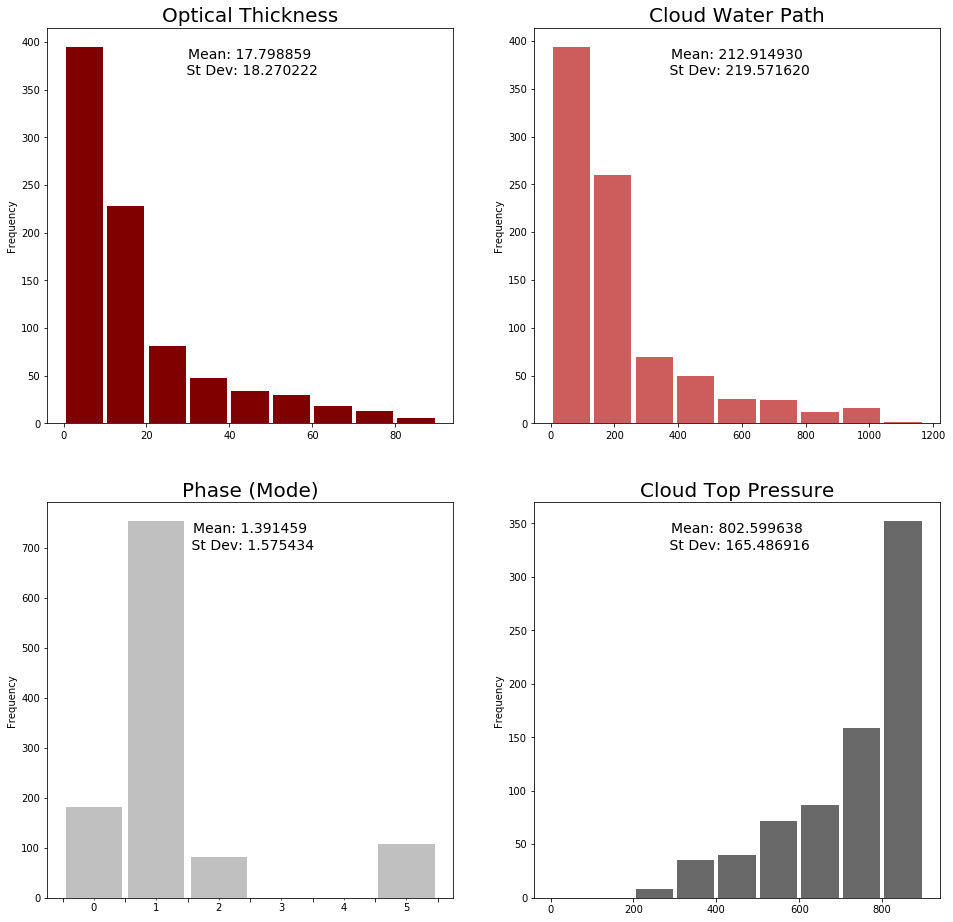

In [72]:
data = [ot,wp,pi,tp]
fig = plt.figure(figsize=(16,16))
titles = [
    "Optical Thickness",
    "Cloud Water Path",
    "Phase (Mode)",
    "Cloud Top Pressure"
]
color = ['maroon','indianred','silver','dimgray']
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    if i == 0:
        plt.hist(data[i], bins=range(0, 100, 10), rwidth=.9, color=color[i])
    elif i == 1:
         plt.hist(data[i], bins=range(0, 1300, 130), rwidth=.9, color=color[i])
    elif i ==2:
        #ax.set_xticks([float(n)+1.5 for n in ax.get_xticks()])
        ax.set_xticklabels('')
        ax.set_xticks([.5,1.5,2.5,3.5,4.5,5.5],      minor=True)
        ax.set_xticklabels(['0','1','2','3','4','5'], minor=True)
        plt.hist(data[i], bins=range(0, 7, 1), rwidth=.9, color=color[i])
    else: 
         plt.hist(data[i], bins=range(0, 1000, 100), rwidth=.9, color=color[i])
    plt.title(titles[i], fontsize=20)
    plt.ylabel("Frequency")
    plt.text(.5,.95,"Mean: %f\n St Dev: %f" % (means[i], devs[i]),horizontalalignment='center',
        verticalalignment='top',
        transform=ax.transAxes, fontsize=14)
#plt.show()
#plt.savefig("Compare/Total_means_04_refined")
#plt.close()

In [73]:
def compute_patch_stats(img_array, statistics=statistics, n_cluster=12):
    #intensity = []
    physics = []
    for icluster in range(n_cluster):
        # get index
        cluster_idx = np.where(img_array == icluster)
        physics += [statistics[cluster_idx]]
    return physics

In [74]:
img1_physics = compute_patch_stats(img1_array, n_cluster=n_clusters) 
img2_physics = compute_patch_stats(img2_array, n_cluster=n_clusters)
cimg_physics = compute_patch_stats(cimg_array, n_cluster=n_clusters)

In [146]:
c = cluster_idx
patches_mean[c].shape

(55, 6)

In [149]:
c_x, c_y = cluster_idx
patches_mean[c_x,c_y].shape

(55, 6)

In [181]:
tru, tot = 0, 0
val_list = ~np.isnan(cimg_array.flatten())
for v in val_list: 
    if v: 
        tru += 1
        tot += 1
    else: 
        tot += 1
tru/tot

0.6223938223938223

In [121]:
physics = []
for icluster in range(1):
    c_x, c_y = np.where(cimg_array == icluster)
    physics.append([patches_mean[c_x][c_y]])
physics

[[array([[13.96229015,  3.14385041,  0.5006081 ,  3.39379901,  7.71271165,
           8.38668809],
         [15.4652954 ,  3.51824371,  0.43649255,  3.35687502,  6.98687748,
           7.72840016],
         [17.48285107,  3.82227104,  0.42033609,  3.34668673,  6.64236496,
           7.40544447],
         [16.6293918 ,  3.32669324,  0.3677232 ,  3.33997197,  6.35146556,
           7.13349063],
         [14.37016376,  3.70402801,  0.39184909,  3.66732799,  6.41524407,
           7.21102773],
         [14.77786465,  3.75407096,  0.50656334,  3.29950739,  7.3760552 ,
           8.08869346],
         [14.25430465,  3.43393816,  0.52161083,  3.30227274,  7.73531254,
           8.43784796],
         [13.80679579,  3.0315482 ,  0.47427151,  3.30934243,  7.33203322,
           8.01039848],
         [15.62863718,  3.37701682,  0.41216712,  3.23736652,  6.44896723,
           7.19865201],
         [17.22365108,  3.59926441,  0.36828999,  3.27476476,  6.14214051,
           6.95957049],
         [

In [155]:
def compute_patch_stats_3d(img_array, statistics=statistics, n_cluster=12):
    #intensity = []
    physics = []
    b1, b2, b3, b4, b5, b6 = [], [], [], [], [], []
    bands = [b1,b2,b3,b4,b5,b6]
    for band in range(statistics.shape[2]):
        for icluster in range(n_cluster):
            # get index
            cluster_idx = np.where(img_array == icluster)
            band_stat = statistics[:,:,band]
            bands[band] += [band_stat[cluster_idx]]
    return bands

In [156]:
patches_mean = np.nanmean(patches, axis=(2,3))
rad_physics = compute_patch_stats_3d(cimg_array, statistics=patches_mean, n_cluster=n_clusters)

/home/sydneyjenkins/.conda/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [184]:
patches_mean = np.nanmean(patches, axis=(2,3))
rad_physics2 = compute_patch_stats(cimg_array, statistics=patches_mean, n_cluster=n_clusters)

/home/sydneyjenkins/.conda/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [185]:
rad_physics

[[array([13.96229015, 15.4652954 , 17.48285107, 16.6293918 , 14.37016376,
         14.77786465, 14.25430465, 13.80679579, 15.62863718, 17.22365108,
         13.97287118, 14.58914201, 15.08792111, 14.18790677, 15.86141617,
         13.59071173, 12.16590807, 14.64775148, 15.20664549, 13.30247698,
         18.42700537, 10.83889679, 13.72272667, 12.52804534, 18.98085273,
         23.00019109, 17.34623235, 12.81270963, 16.16650029, 20.95469018,
          9.62342842, 11.4724738 , 16.46594446, 22.22903699, 16.62584379,
         11.4021996 , 10.72974471, 13.11081659, 12.15276315, 10.6485648 ,
         19.2539138 , 18.18413143, 15.78568637, 10.45764234, 12.61727947,
         11.25602336, 10.59303638, 11.29778729,  9.95590504, 11.20094844,
         13.08617599, 10.60022068, 12.59158558, 14.09665069, 14.18750764]),
  array([12.20353384,  8.2792855 ,  8.70030503,  9.62020872,  8.56019365,
          7.29756179,  6.45248506,  4.6541575 ,  5.88240274,  7.30724531,
          8.78732886,  9.45110896, 1

In [186]:
rad_physics2

[array([[13.96229015,  3.14385041,  0.5006081 ,  3.39379901,  7.71271165,
          8.38668809],
        [15.4652954 ,  3.51824371,  0.43649255,  3.35687502,  6.98687748,
          7.72840016],
        [17.48285107,  3.82227104,  0.42033609,  3.34668673,  6.64236496,
          7.40544447],
        [16.6293918 ,  3.32669324,  0.3677232 ,  3.33997197,  6.35146556,
          7.13349063],
        [14.37016376,  3.70402801,  0.39184909,  3.66732799,  6.41524407,
          7.21102773],
        [14.77786465,  3.75407096,  0.50656334,  3.29950739,  7.3760552 ,
          8.08869346],
        [14.25430465,  3.43393816,  0.52161083,  3.30227274,  7.73531254,
          8.43784796],
        [13.80679579,  3.0315482 ,  0.47427151,  3.30934243,  7.33203322,
          8.01039848],
        [15.62863718,  3.37701682,  0.41216712,  3.23736652,  6.44896723,
          7.19865201],
        [17.22365108,  3.59926441,  0.36828999,  3.27476476,  6.14214051,
          6.95957049],
        [13.97287118,  3.86680

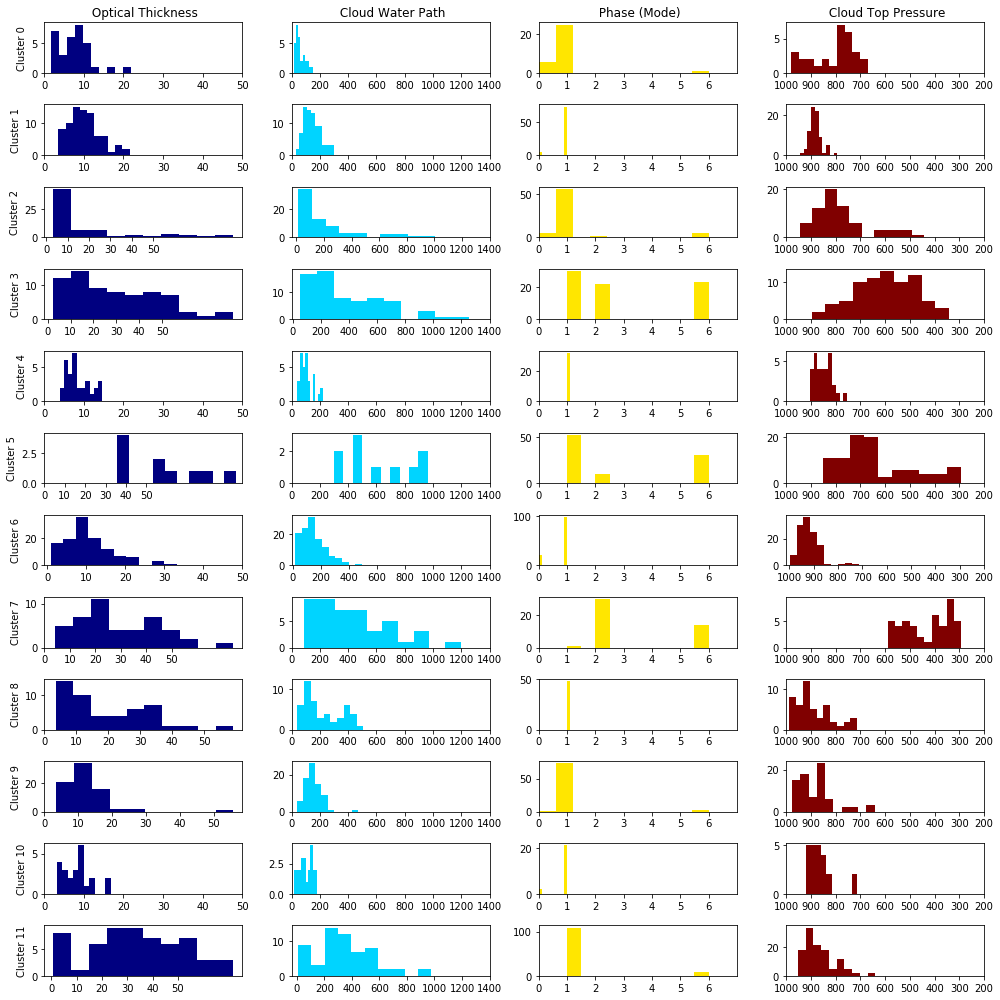

In [75]:
fig = plt.figure(figsize=(14,14))
it = 1
phys_colors = _get_colors(n=4)
for i in range(n_clusters):
    for k in range(4):
        ax = plt.subplot(n_clusters, 4, it)
        tmp = img1_physics[i][:,k]
        tmp = tmp[np.logical_not(np.isnan(tmp))]
        plt.hist(tmp, color=phys_colors[k])
        if i == 0:
            ax.set_title(" %s" % titles[k])   
        if k == 0:
            ax.set_ylabel("Cluster %d" % i)
            ax.set_xticks([l for l in range(0,60, 10)])
        elif k ==1 :
            ax.set_xticks([l for l in range(0,1500,200)])
        elif k == 2:
            ax.set_xticks([l for l in range(0,7,1)])
            ax.set_xlim(0,7)
        elif k ==3:
            ax.set_xticks([l for l in range(200,1001,100)])
            ax.invert_xaxis()
        it += 1
fig.tight_layout()
#plt.savefig("Compare/img1_04")
#plt.close()

In [399]:
fig = plt.figure(figsize=(14,14))
it = 1
phys_colors = _get_colors(n=4)
for i in range(n_clusters):
    for k in range(4):
        ax = plt.subplot(n_clusters, 4, it)
        #===============================================
        # change here
        #===============================================
        tmp = img2_physics[i][:,k]
        #===============================================
        tmp = tmp[np.logical_not(np.isnan(tmp))]
        plt.hist(tmp, color=phys_colors[k])
        if i == 0:
            ax.set_title(" %s" % titles[k])   
        if k == 0:
            ax.set_ylabel("Cluster %d" % i)
            ax.set_xticks([l for l in range(0,60, 10)])
        elif k ==1 :
            ax.set_xticks([l for l in range(0,1500,200)])
        elif k == 2:
            ax.set_xticks([l for l in range(0,7,1)])
            ax.set_xlim(0,7)
        elif k ==3:
            ax.set_xticks([l for l in range(200,1001,100)])
            ax.invert_xaxis()
        it += 1
fig.tight_layout()
plt.savefig("Compare/img2_04")
plt.close()

In [ ]:
ho

In [84]:
fig = plt.figure(figsize=(14,14))
it = 1
phys_colors = ['maroon','indianred','silver','dimgray']
for i in range(n_clusters):
    for k in range(4):
        ax = plt.subplot(n_clusters, 4, it)
        #===============================================
        # change here
        #===============================================
        tmp = cimg_physics[i][:,k]
        #===============================================
        tmp = tmp[np.logical_not(np.isnan(tmp))]  
        if k == 0:
            plt.hist(tmp, bins=range(0, 60, 3), color=phys_colors[k],rwidth=.8)
            ax.set_ylabel("Cluster %d" % i)
            ax.set_xticks([l for l in range(0,60, 10)])
        elif k ==1 :
            plt.hist(tmp, bins=range(0, 1500, 75), color=phys_colors[k],rwidth=.8)
            ax.set_xticks([l for l in range(0,1500,200)])
        elif k == 2:
            plt.hist(tmp, bins=range(0, 7, 1), color=phys_colors[k],rwidth=.8)
            ax.set_xticks([l for l in range(0,7,1)])
            ax.set_xlim(0,7)
            ax.set_xticklabels('')
            ax.set_xticks([.5,1.5,2.5,3.5,4.5,5.5,6.5],      minor=True)
            ax.set_xticklabels(['0','1','2','3','4','5','6'], minor=True)
        elif k ==3:
            plt.hist(tmp, bins=range(200, 1000, 40), color=phys_colors[k],rwidth=.8)
            ax.set_xticks([l for l in range(200,1001,100)])
            ax.invert_xaxis()
        if i == 0:
            ax.set_title(" %s" % titles[k]) 
        it += 1
fig.tight_layout()
#plt.savefig("Compare/cimg_04_refined")
#plt.close()

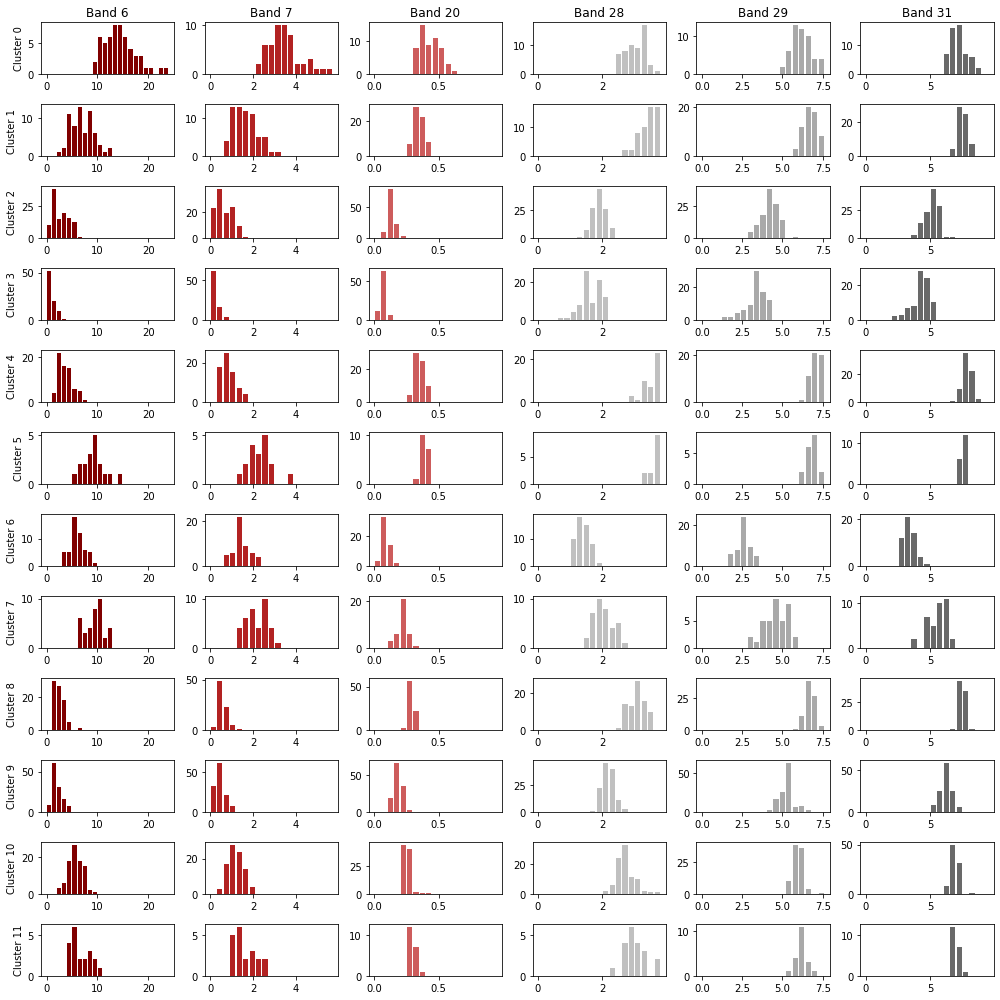

In [188]:
##RADIATION
fig = plt.figure(figsize=(14,14))
it = 1
phys_colors = ['maroon','firebrick','indianred','silver','darkgray','dimgray']
bands = [6, 7, 20, 28, 29, 31] 
for i in range(n_clusters):
    for k in range(patches_mean.shape[2]):
        ax = plt.subplot(n_clusters, patches_mean.shape[2], it)
        #===============================================
        # change here
        #===============================================
        tmp = rad_physics[k][i]
        #===============================================
        tmp = tmp[np.logical_not(np.isnan(tmp))]  
        if k == 0:
            b = np.arange(0,25,1)
            plt.hist(tmp, bins=b,color=phys_colors[k],rwidth=.8)
            ax.set_ylabel("Cluster %d" % i)
           # ax.set_xticks([l for l in range(0,60, 10)])
        elif k ==1 :
            b = np.arange(0,6,.3)
            plt.hist(tmp, bins=b,color=phys_colors[k],rwidth=.8)
           # ax.set_xticks([l for l in range(0,1500,200)])
        elif k == 2:
            b = np.arange(0,1,.05)
            plt.hist(tmp, bins=b,color=phys_colors[k],rwidth=.8)
           # ax.set_xticks([l for l in range(0,7,1)])
           # ax.set_xlim(0,7)
        elif k ==3:
            b = np.arange(0,4,.2)
            plt.hist(tmp, bins=b, color=phys_colors[k],rwidth=.8)
           # ax.set_xticks([l for l in range(200,1001,100)]) 
        elif k ==4:
            b = np.arange(0,8,.4)
            plt.hist(tmp, bins=b, color=phys_colors[k],rwidth=.8)
        elif k ==5:
            b = np.arange(0,10,.5)
            plt.hist(tmp, bins=b, color=phys_colors[k],rwidth=.8)
        if i == 0:
            ax.set_title("Band %d" % bands[k]) 
        it += 1
fig.tight_layout()

#plt.savefig("Compare/Rad_per_cluster_04")
#plt.close()

### Examine intensity (radiation of original data)
Compute mean radiation and plot its distribution.

In [88]:
patches_mean = np.nanmean(patches, axis=(2,3))
patches_mean.shape[2]

/home/sydneyjenkins/.conda/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


6

/home/sydneyjenkins/.conda/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


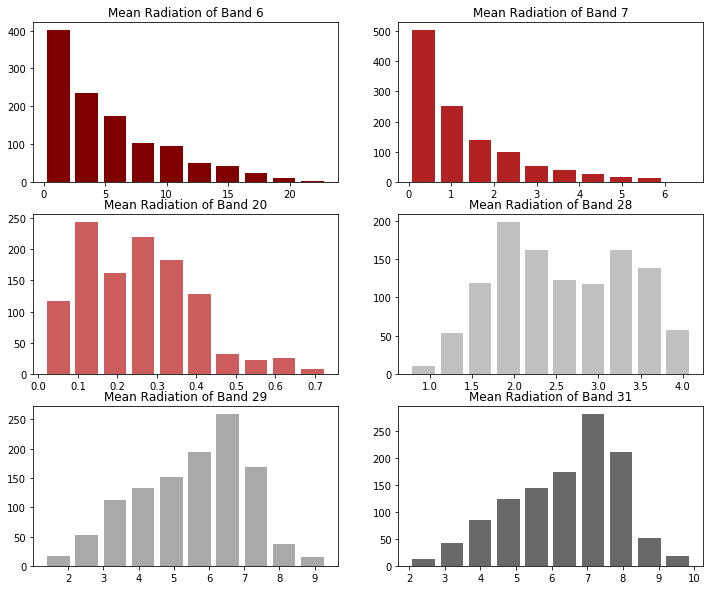

In [191]:
patches_mean = np.nanmean(patches, axis=(2,3))
fig = plt.figure(figsize=(12,10))
bands = [6, 7, 20, 28, 29, 31] 
colors = ['maroon','firebrick','indianred','silver','darkgray','dimgray']
for b in range(patches_mean.shape[2]):
    ax = plt.subplot(3,2,b+1)
    plt.hist(patches_mean[:,:,b].flatten(),rwidth=.8, color=colors[b])
    plt.title("Mean Radiation of Band %d" % (bands[b]))
#plt.savefig("Compare/Mean_radiation")
#plt.close()

In [403]:
vis_file = '../tak_data/MOD02/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_250_Aggr1km_RefSB_1.hdf'
vhdf = SD(vis_file, SDC.READ)
vhdf_sds = vhdf.select("EV_250_Aggr1km_RefSB")
vhdf_array, vis_band = proc_sds(vhdf_sds)

Process bands 1


/scratch/midway2/sydneyjenkins/clouds/analysis_mod021KM/lib_modis02.py:90: RuntimeWarning: invalid value encountered in greater
  invalid_idx = np.where( array > 32767 )


In [407]:
fig = plt.figure(figsize=(20,20))

line_width = 2
SHAPE = 128,128
colors = _get_colors(n=n_clusters)
for idx, icluster in enumerate(range(12)):
    ax = plt.subplot(4,3,idx+1)
    plt.imshow(vhdf_array, cmap='bone')
    ax.set_title("cluster == %d" % idx)
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            #==============================================
            if not np.isnan(cimg_array[i,j]):
                if cimg_array[i,j] == icluster:
                    #======================================
                    ax.add_patch(mpl_patches.Rectangle(
                      (j * SHAPE[0] + line_width , i * SHAPE[1] + line_width ),
                      width=SHAPE[0] - line_width * 2,
                      height=SHAPE[1] - line_width * 2,
                      linewidth=1,
                      edgecolor=colors[int(cimg_array[i,j])],
                      facecolor="none"                 
                      ))
fig.tight_layout()
plt.savefig("Compare/Visual_clusters_04")
plt.close()

In [408]:
_namelist = [
    "Optical Thickness [unit-less]",
    "Cloud Water Path [g/m^2]",
    "Phase [0,1,2,3,6]",
    "Cloud Top Pressure [hpa]"
]

In [416]:
fig = plt.figure(figsize=(8,8))
for idx, i in enumerate(range(4)):
    ax = plt.subplot(2,2,idx+1)
    plt.imshow(statistics[:,:,i], cmap='jet')
    plt.colorbar()
    ax.set_title("%s" % _namelist[idx])
fig.tight_layout()
plt.savefig("Compare/Patch_stats_04")
plt.close()

In [87]:
patches

array([[[[[1.55247497e+01, 3.93947326e+00, 5.91447000e-01,
           3.76191343e+00, 8.79850352e+00, 9.26179715e+00],
          [1.53803968e+01, 3.82083995e+00, 5.84433114e-01,
           3.74632500e+00, 8.80755580e+00, 9.26095713e+00],
          [1.58760993e+01, 3.93523636e+00, 5.91885368e-01,
           3.73497046e+00, 8.83151771e+00, 9.26851733e+00],
          ...,
          [1.43672026e+01, 3.49459835e+00, 5.49614178e-01,
           3.76999631e+00, 8.66804422e+00, 9.11395328e+00],
          [1.42065078e+01, 3.44799241e+00, 5.54123105e-01,
           3.78269800e+00, 8.68295385e+00, 9.13747390e+00],
          [1.48574578e+01, 3.71237521e+00, 5.61074367e-01,
           3.78231310e+00, 8.66378432e+00, 9.14503409e+00]],

         [[1.53858440e+01, 3.84541399e+00, 5.87000697e-01,
           3.75440789e+00, 8.82299792e+00, 9.27859759e+00],
          [1.55656043e+01, 3.83694019e+00, 5.84996730e-01,
           3.75690973e+00, 8.82885528e+00, 9.26179715e+00],
          [1.57589828e+01, 4.04